In [1]:
import tarfile
tar = tarfile.open('data.tar.gz')
tar.extractall()

In [2]:
pip install split-folders

In [3]:
import splitfolders
splitfolders.ratio("/content/Resize", output="splitted_data", seed=43, ratio=(.8,.1,.1))

Copying files: 5299 files [00:00, 6152.45 files/s]


Number of train dataset:  4238
Number of test dataset:  532
Number of validation dataset:  529


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


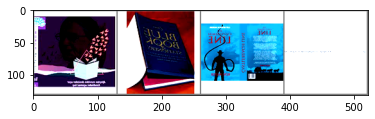

Epoch: 1 	Training Loss: 1.105839
Epoch: 2 	Training Loss: 1.097296
Epoch: 3 	Training Loss: 1.092925
Epoch: 4 	Training Loss: 1.091598
Epoch: 5 	Training Loss: 1.091399
Epoch: 6 	Training Loss: 1.087972
Epoch: 7 	Training Loss: 1.087993
Epoch: 8 	Training Loss: 1.083715
Epoch: 9 	Training Loss: 1.082475
Epoch: 10 	Training Loss: 1.083707
Epoch: 11 	Training Loss: 1.079545
Epoch: 12 	Training Loss: 1.077442
Epoch: 13 	Training Loss: 1.079239
Epoch: 14 	Training Loss: 1.075381
Epoch: 15 	Training Loss: 1.069462
Epoch: 16 	Training Loss: 1.062373
Epoch: 17 	Training Loss: 1.064481
Epoch: 18 	Training Loss: 1.064815
Epoch: 19 	Training Loss: 1.063943
Epoch: 20 	Training Loss: 1.059294
Epoch: 21 	Training Loss: 1.053507
Epoch: 22 	Training Loss: 1.057621
Epoch: 23 	Training Loss: 1.046300
Epoch: 24 	Training Loss: 1.042695
Epoch: 25 	Training Loss: 1.039045
Epoch: 26 	Training Loss: 1.030120
Epoch: 27 	Training Loss: 1.039027
Epoch: 28 	Training Loss: 1.035933
Epoch: 29 	Training Loss: 1.0

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 75
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

# Define datasets as train, test and validation.
train_dataset = torchvision.datasets.ImageFolder(root='/content/splitted_data/train', 
                                                 transform=transform)
print("Number of train dataset: ",len(train_dataset))
test_dataset = torchvision.datasets.ImageFolder(root='/content/splitted_data/test',
                                                transform=transform)
print("Number of test dataset: ",len(test_dataset))
valid_dataset = torchvision.datasets.ImageFolder(root='/content/splitted_data/val',
                                                transform=transform2)
print("Number of validation dataset: ",len(valid_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ("book_cover", "magazine_cover", "movie_poster")

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3*128 * 128, 120)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(120, 120)
        # linear layer (n_hidden -> 3)
        self.fc3 = nn.Linear(120, 3)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add hidden layer, with relu activation function
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        return x

model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    train_loss=0.
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

print('Finished Training')
print("-"*50)


# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))